In [1]:
%pylab inline
import gdr2_completeness.data_manipulation as dr2
from astropy.io import fits
from healpy import ang2pix

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Relevant data can be found here: https://keeper.mpdl.mpg.de/d/f2b841c75d7a42f6aad9/

#x = np.genfromtxt('../../data/scanning law/DEOPTSK-1327_Gaia_scanlaw.csv.gz', delimiter=',', names = True, dtype = None)
#np.savez_compressed('../../data/scanning law/scanlaw.npz',x)
x = np.load('../../data/scanning law/scanlaw.npz')['arr_0']
x = x[::5]
x = x.view(np.recarray)
x.dtype

dtype((numpy.record, [('JulianDayNumberRefEpoch2010TCBGaia', '<f8'), ('JulianDayNumberRefEpoch2010TCBBarycentre_1', '<f8'), ('JulianDayNumberRefEpoch2010TCBBarycentre_2', '<f8'), ('ra_FOV_1deg', '<f8'), ('dec_FOV_1deg', '<f8'), ('scanPositionAngle_FOV_1deg', '<f8'), ('ra_FOV_2deg', '<f8'), ('dec_FOV_2deg', '<f8'), ('scanPositionAngle_FOV_2deg', '<f8')]))

In [3]:
# Correct way:
# 10 sec intervals = 10 arcminutes rotation, rotation rate 59.9641857803 arcsec/sec
# for all healpix within 0.7/2 deg see if it was covered by a FoV transit (only do once per pixel in a transit)

# Approximated way:
# - for healpix level 6: 1 HEALpix ~0.8 squaredegree. 
# That means distance between HEALpixes is around 0.9 degree = 54 arcminutes.
# - just chose the HEALpix every 50 seconds and coadd the sourcenumber of the second field of view per transit

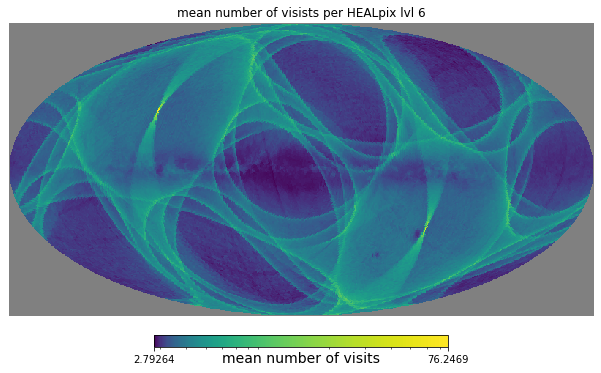

In [4]:
def plot_mollweide_log(data, title, unit):
    import healpy as hp
    from matplotlib.colors import LogNorm
    import matplotlib.pylab as plt
    norm = LogNorm()
    map_mollweide = data        
    total = np.nansum(map_mollweide)
    hp.mollview(map_mollweide, cbar = True, min=None, max=None, nest = True,norm = norm, coord= "CG",
                unit = unit,notext =True)
    plt.title(title)        
    plt.show()

# Can comment the next two lines out if you don't want to download extra files.
mvisits = fits.getdata('../../data/python_plotting/mean_visits_level_6.fits')['mean_transits']
plot_mollweide_log(mvisits, 'mean number of visists per HEALpix lvl 6', 'mean number of visits')

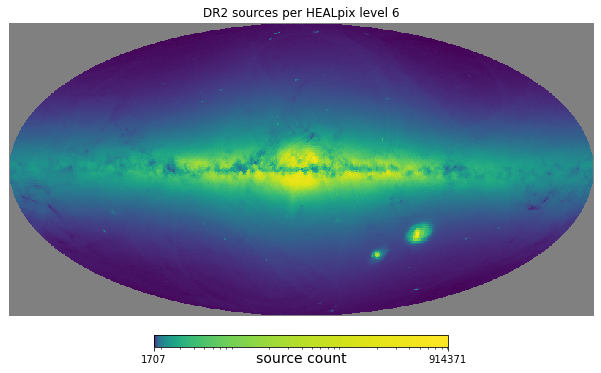

0 1154383
100000 1154383
200000 1154383
300000 1154383
400000 1154383
500000 1154383
600000 1154383
700000 1154383
800000 1154383
900000 1154383
1000000 1154383
1100000 1154383


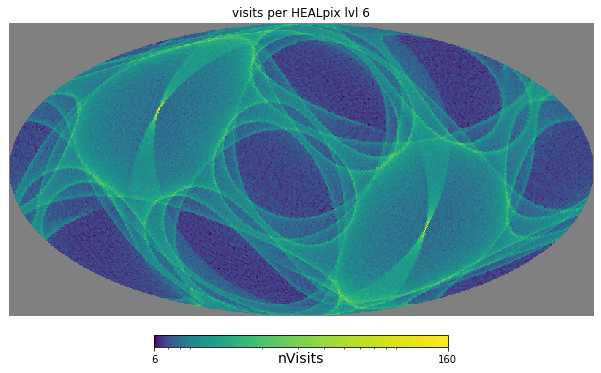

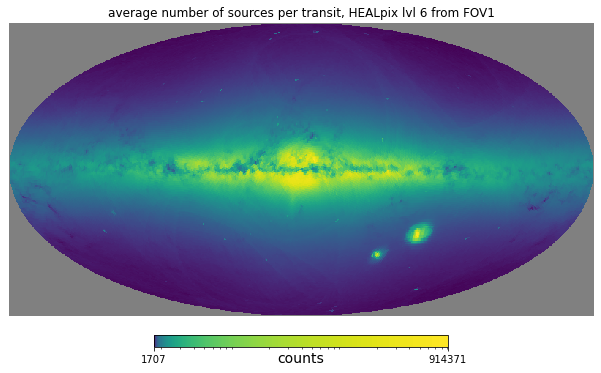

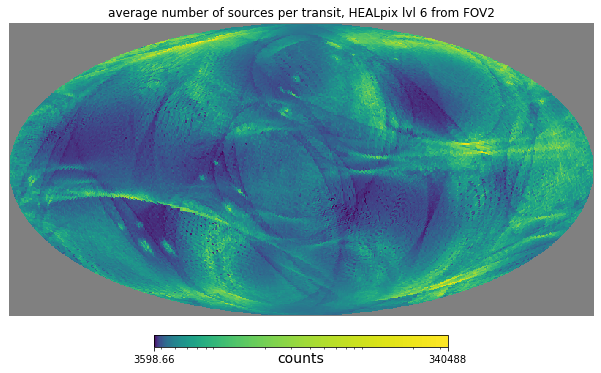

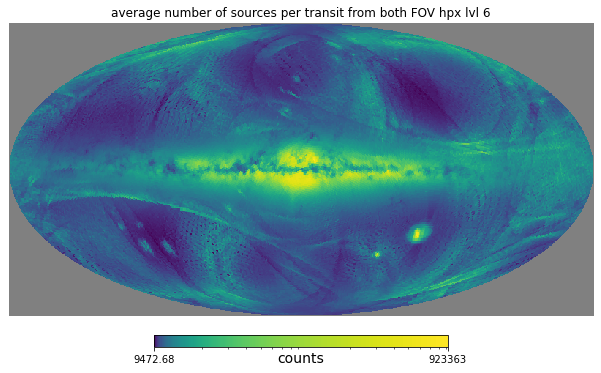

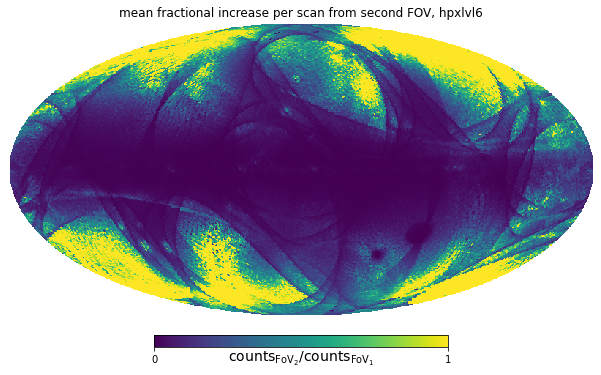

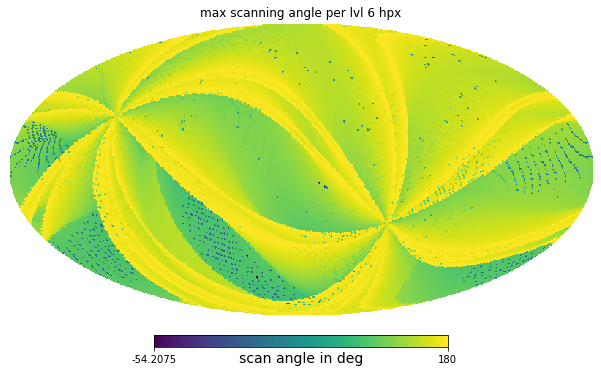

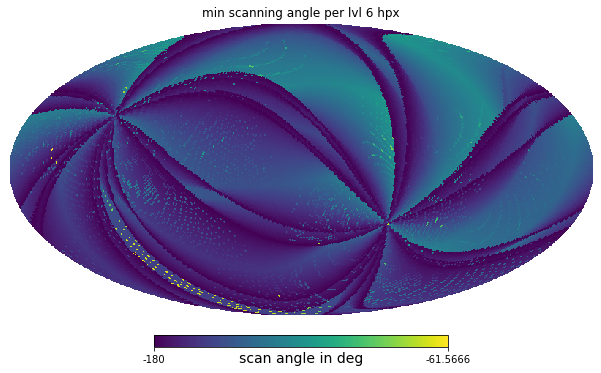

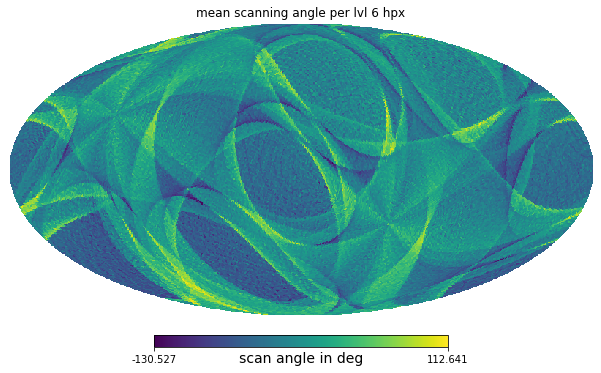

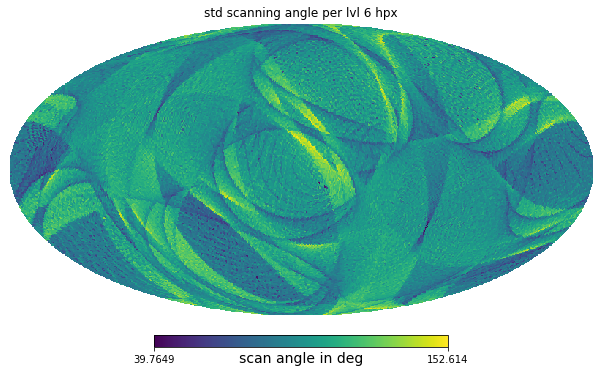

In [5]:
# We are using all sources here
density = np.genfromtxt('../../data/scanning law/gdr2_source_density_lvl6.csv', names = True, dtype = np.int32)['ct']
plot_mollweide_log(density, 'DR2 sources per HEALpix level 6', 'source count')

# preparing the arrays
visits1 = np.zeros(49152).astype(np.int32)
visits2 = np.zeros(49152).astype(np.int32)
scangle_min = np.ones(49152)*180
scangle_max = np.ones(49152)*-180
scangle_mean_array = np.ones(shape=(49152,160))*np.nan
ct2 = np.zeros(49152).astype(np.int64)
ct1 = np.zeros_like(ct2)
ctall = np.zeros_like(ct2)

# Loop over the pointings and aggregate statistics
for i in range(len(x)):
    if i%100000 == 0:
        print(i, len(x))
    nhpx1 = ang2pix(64,x.ra_FOV_1deg[i],x.dec_FOV_1deg[i], nest= True,lonlat = True) 
    nhpx2 = ang2pix(64,x.ra_FOV_2deg[i],x.dec_FOV_2deg[i], nest= True,lonlat = True) 
    visits1[nhpx1] += 1
    ct1[nhpx1] += density[nhpx1]
    ct2[nhpx1] += density[nhpx2]
    if scangle_min[nhpx1] > x.scanPositionAngle_FOV_1deg[i]:
        scangle_min[nhpx1] = x.scanPositionAngle_FOV_1deg[i]
    if scangle_max[nhpx1] < x.scanPositionAngle_FOV_1deg[i]:
        scangle_max[nhpx1] = x.scanPositionAngle_FOV_1deg[i]
    scangle_mean_array[nhpx1,visits1[nhpx1]-1] = x.scanPositionAngle_FOV_1deg[i]

scangle_mean = np.nanmean(scangle_mean_array,axis=1)
scangle_std = np.nanstd(scangle_mean_array,axis=1)
# faster:
#nhpx = ang2pix(64,x.ra_FOV_1deg,x.dec_FOV_1deg, nest= True,lonlat = True)
#_, visits1 = np.unique(nhpx,return_counts=True)


# Plot the results
plot_mollweide_log(visits1,'visits per HEALpix lvl 6', 'nVisits')

plot_mollweide_log(np.divide(ct1,visits1),'average number of sources per transit, HEALpix lvl 6 from FOV1', 'counts')
plot_mollweide_log(np.divide(ct2,visits1),'average number of sources per transit, HEALpix lvl 6 from FOV2', 'counts')
plot_mollweide_log(np.divide(ct1 + ct2,visits1), 'average number of sources per transit from both FOV hpx lvl 6', 'counts')

def plot_mollweide_linear(data,title,unit):
    import healpy as hp
    import matplotlib.pylab as plt

    map_mollweide = data
    hp.mollview(map_mollweide, cbar = True, nest = True, coord= "CG", unit = unit,notext =True,min = 0, max = 1)
    plt.title(title)
    plt.show()    

plot_mollweide_linear(np.divide(np.divide(ct2,ct1),visits1),'mean fractional increase per scan from second FOV, hpxlvl6',
                      r'$\mathrm{counts}_\mathrm{FoV_2}/\mathrm{counts}_\mathrm{FoV_1}$')
# Plotting the scanning angles
def plot_mollweide_linear(data,title,unit):
    import healpy as hp
    import matplotlib.pylab as plt

    map_mollweide = data
    hp.mollview(map_mollweide, cbar = True, nest = True, coord= "CG", unit = unit,notext =True)#,min = 0, max = 1)
    plt.title(title)
    plt.show()    

plot_mollweide_linear(scangle_max,'max scanning angle per lvl 6 hpx','scan angle in deg')
plot_mollweide_linear(scangle_min,'min scanning angle per lvl 6 hpx','scan angle in deg')
plot_mollweide_linear(scangle_mean,'mean scanning angle per lvl 6 hpx','scan angle in deg')
plot_mollweide_linear(scangle_std,'std scanning angle per lvl 6 hpx','scan angle in deg')

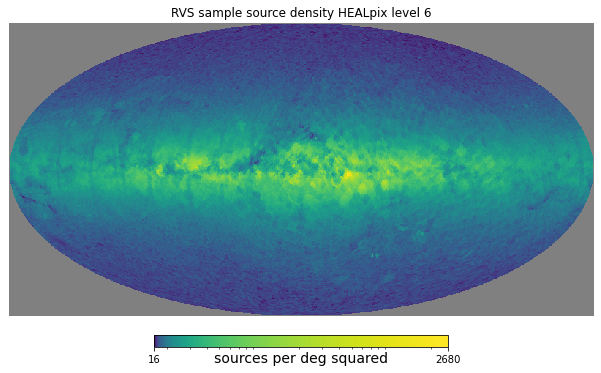

0 1154383
100000 1154383
200000 1154383
300000 1154383
400000 1154383
500000 1154383
600000 1154383
700000 1154383
800000 1154383
900000 1154383
1000000 1154383
1100000 1154383


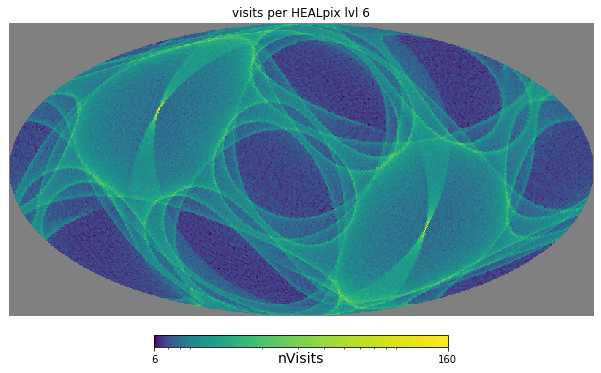

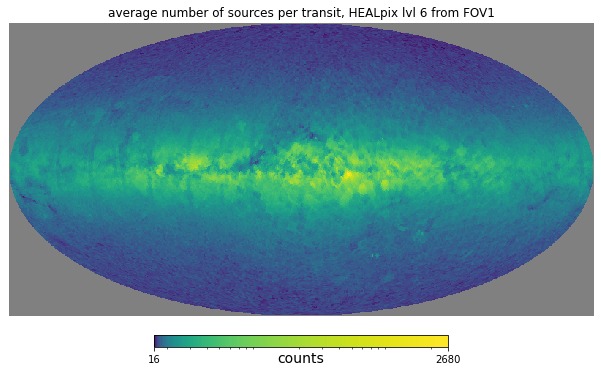

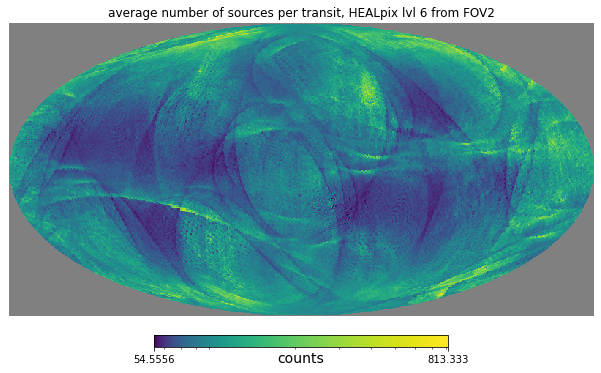

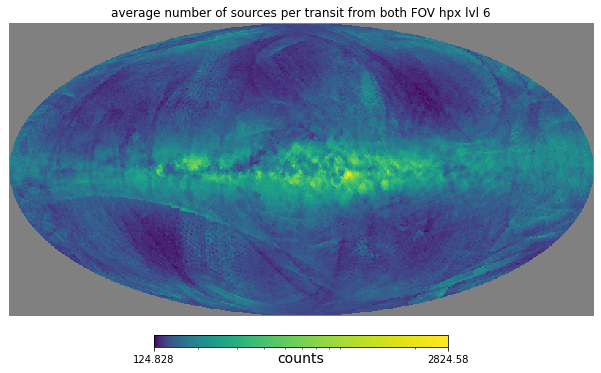

mean fractional increase per scan from second FOV,hpxlvl6


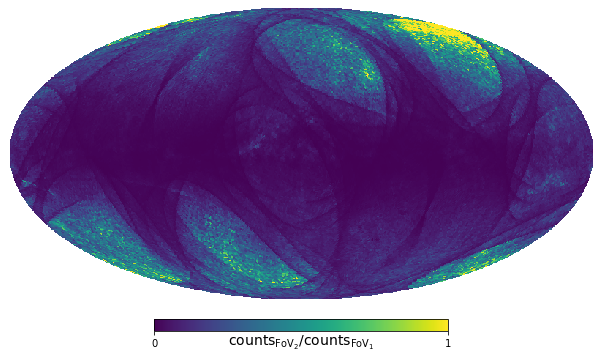

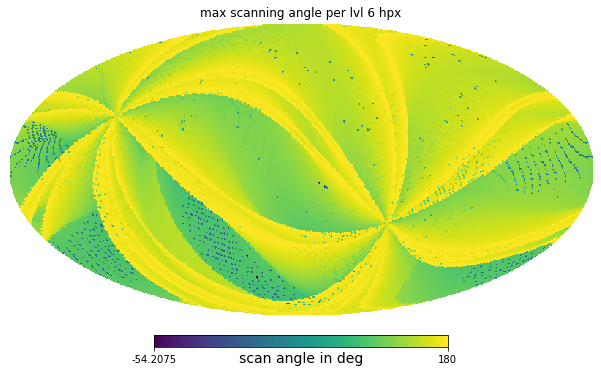

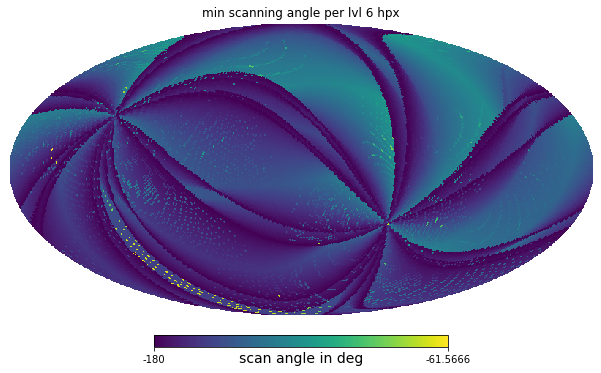

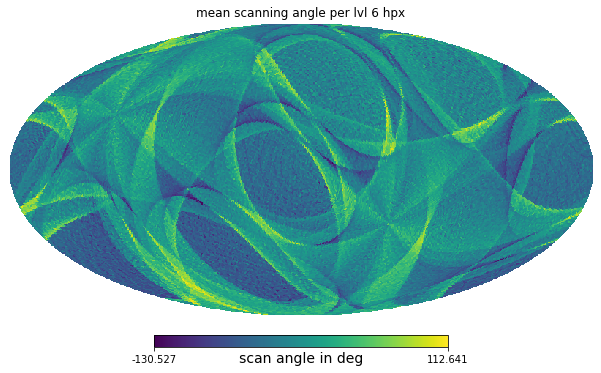

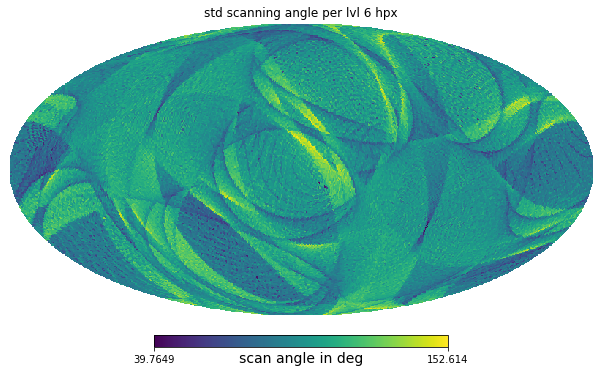

In [6]:
# Could do the same with RVS sources only
density = fits.getdata('../../data/python_plotting/rvs_density_hpxlvl_6.fits')['density'].astype(np.int64)
plot_mollweide_log(density, 'RVS sample source density HEALpix level 6', 'sources per deg squared')

# preparing the arrays
visits1 = np.zeros(49152).astype(np.int32)
visits2 = np.zeros(49152).astype(np.int32)
scangle_min = np.ones(49152)*180
scangle_max = np.ones(49152)*-180
scangle_mean_array = np.ones(shape=(49152,160))*np.nan
ct2 = np.zeros(49152).astype(np.int64)
ct1 = np.zeros_like(ct2)
ctall = np.zeros_like(ct2)

# Loop over the pointings and aggregate statistics
for i in range(len(x)):
    if i%100000 == 0:
        print(i, len(x))
    nhpx1 = ang2pix(64,x.ra_FOV_1deg[i],x.dec_FOV_1deg[i], nest= True,lonlat = True) 
    nhpx2 = ang2pix(64,x.ra_FOV_2deg[i],x.dec_FOV_2deg[i], nest= True,lonlat = True) 
    visits1[nhpx1] += 1
    ct1[nhpx1] += density[nhpx1]
    ct2[nhpx1] += density[nhpx2]
    if scangle_min[nhpx1] > x.scanPositionAngle_FOV_1deg[i]:
        scangle_min[nhpx1] = x.scanPositionAngle_FOV_1deg[i]
    if scangle_max[nhpx1] < x.scanPositionAngle_FOV_1deg[i]:
        scangle_max[nhpx1] = x.scanPositionAngle_FOV_1deg[i]
    scangle_mean_array[nhpx1,visits1[nhpx1]-1] = x.scanPositionAngle_FOV_1deg[i]

scangle_mean = np.nanmean(scangle_mean_array,axis=1)
scangle_std = np.nanstd(scangle_mean_array,axis=1)
# faster:
#nhpx = ang2pix(64,x.ra_FOV_1deg,x.dec_FOV_1deg, nest= True,lonlat = True)
#_, visits1 = np.unique(nhpx,return_counts=True)


# Plot the results
plot_mollweide_log(visits1,'visits per HEALpix lvl 6', 'nVisits')

plot_mollweide_log(np.divide(ct1,visits1),'average number of sources per transit, HEALpix lvl 6 from FOV1', 'counts')
plot_mollweide_log(np.divide(ct2,visits1),'average number of sources per transit, HEALpix lvl 6 from FOV2', 'counts')
plot_mollweide_log(np.divide(ct1 + ct2,visits1), 
                   'average number of sources per transit from both FOV hpx lvl 6', 'counts')

def plot_mollweide_linear(data,title,unit):
    import healpy as hp
    import matplotlib.pylab as plt

    map_mollweide = data
    hp.mollview(map_mollweide, cbar = True, nest = True, coord= "CG", unit = unit,notext =True,min = 0, max = 1)
    plt.title(title)
    plt.show()    
print('mean fractional increase per scan from second FOV,hpxlvl6')
plot_mollweide_linear(np.divide(np.divide(ct2,ct1),visits1),
                      '', r'$\mathrm{counts}_\mathrm{FoV_2}/\mathrm{counts}_\mathrm{FoV_1}$')
# Plotting the scanning angles
def plot_mollweide_linear(data,title,unit):
    import healpy as hp
    import matplotlib.pylab as plt

    map_mollweide = data
    hp.mollview(map_mollweide, cbar = True, nest = True, coord= "CG", unit = unit,notext =True)#,min = 0, max = 1)
    plt.title(title)
    plt.show()    

plot_mollweide_linear(scangle_max,'max scanning angle per lvl 6 hpx','scan angle in deg')
plot_mollweide_linear(scangle_min,'min scanning angle per lvl 6 hpx','scan angle in deg')
plot_mollweide_linear(scangle_mean,'mean scanning angle per lvl 6 hpx','scan angle in deg')
plot_mollweide_linear(scangle_std,'std scanning angle per lvl 6 hpx','scan angle in deg')

<Figure size 1200x800 with 0 Axes>

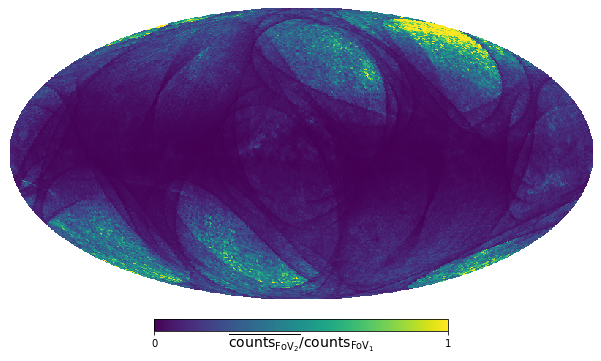

In [7]:
# Paper appendix plot

def plot_mollweide_linear(data,title,unit):
    import healpy as hp
    import matplotlib.pylab as plt

    map_mollweide = data
    hp.mollview(map_mollweide, cbar = True, nest = True, coord= "CG", unit = unit,notext =True,min = 0, max = 1)
    plt.title(title)
    plt.show()    
plt.figure(dpi=200)
plot_mollweide_linear(np.divide(np.divide(ct2,ct1),visits1),
                      '', r'$\overline{\mathrm{counts}_\mathrm{FoV_2}}/\mathrm{counts}_\mathrm{FoV_1}$')